## 6. Data Cleaning

Before proceeding with analysis, we perform comprehensive data cleaning to ensure data quality and validity. This section documents all cleaning steps and justifies why additional cleaning is or isn't necessary.

### 6.1 Ingredient Name Normalization (Already Completed)

**Purpose**: Standardize ingredient names to eliminate duplicates caused by different phrasings, spellings, and formatting.

**Method**: We utilized the pre-processed ingredient normalization table (from `ingredients.json`) that maps raw ingredient strings to canonicalized forms. This mapping was generated with the help of an LLM

**Impact**:
- Consolidated variants like "extra-virgin olive oil", "olive oil", "evoo" → `olive oil`
- Unified measurement variations: "2 cups all-purpose flour" → `flour`
- Standardized plurals and spellings

**Note**: This step was applied during the transformation phase (Section 5) when converting ingredient IDs to canonical names.

### 6.2 Check for Missing Values

In [3]:
import pandas as pd
df = pd.read_csv('dataset/prepared_recipes_raw.csv')

print("=" * 60)
print("MISSING VALUES CHECK")
print("=" * 60)

# Check for null values
missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_percentages
})

print("\nMissing values by column:")
print(missing_df)

# Check for empty strings in ingredients
empty_ingredients = df[df['ingredients'] == ''].shape[0]
print(f"\nRecipes with empty ingredient lists: {empty_ingredients}")

# Check for zero ingredient counts
zero_count = df[df['ingredient_count'] == 0].shape[0]
print(f"Recipes with zero ingredients: {zero_count}")

print("\nNo missing values detected" if df.isnull().sum().sum() == 0 and empty_ingredients == 0 else "Missing values found")

MISSING VALUES CHECK

Missing values by column:
                  Missing Count  Percentage
recipe_id                     0         0.0
cuisine                       0         0.0
ingredients                   0         0.0
ingredient_count              0         0.0

Recipes with empty ingredient lists: 0
Recipes with zero ingredients: 0

No missing values detected


### 6.3 Check for Duplicate Recipes

In [4]:
print("=" * 60)
print("DUPLICATE RECIPES CHECK")
print("=" * 60)

# Check for duplicate recipe IDs
duplicate_ids = df['recipe_id'].duplicated().sum()
print(f"\nDuplicate recipe IDs: {duplicate_ids}")

# Check for exact duplicate rows (same cuisine + ingredients)
duplicate_exact = df.duplicated(subset=['cuisine', 'ingredients']).sum()
print(f"Exact duplicate recipes (same cuisine + ingredients): {duplicate_exact}")

# Check for recipes with identical ingredients but different cuisines
# This is actually valid (same dish in different cuisines), not an error
duplicate_ingredients = df.duplicated(subset=['ingredients'], keep=False)
if duplicate_ingredients.any():
    print(f"\nRecipes with identical ingredients across cuisines: {duplicate_ingredients.sum()}")
    print("(This is valid - same ingredient set can appear in multiple cuisines)")
    
print("\nNo problematic duplicates" if duplicate_ids == 0 and duplicate_exact == 0 else "Duplicates found")

DUPLICATE RECIPES CHECK

Duplicate recipe IDs: 0
Exact duplicate recipes (same cuisine + ingredients): 522

Recipes with identical ingredients across cuisines: 1043
(This is valid - same ingredient set can appear in multiple cuisines)
Duplicates found


### 6.4 Validate Data Types and Ranges

In [5]:
print("=" * 60)
print("DATA TYPE AND RANGE VALIDATION")
print("=" * 60)

print("\nColumn data types:")
print(df.dtypes)

# Validate ingredient_count matches actual count in ingredients string
print("\n" + "-" * 60)
print("Validating ingredient_count accuracy...")
print("-" * 60)

df['actual_count'] = df['ingredients'].apply(lambda x: len(x.split(',')) if x else 0)
mismatched = df[df['ingredient_count'] != df['actual_count']]

if len(mismatched) > 0:
    print(f"Found {len(mismatched)} recipes with mismatched counts")
    print(mismatched[['recipe_id', 'ingredient_count', 'actual_count']].head())
else:
    print("All ingredient counts are accurate")

# Check for unrealistic values
print("\n" + "-" * 60)
print("Ingredient count statistics:")
print("-" * 60)
print(df['ingredient_count'].describe())

# Flag suspiciously low or high counts (optional - for reporting only)
very_low = df[df['ingredient_count'] <= 2]
very_high = df[df['ingredient_count'] >= 30]
print(f"\nRecipes with <= 2 ingredients: {len(very_low)} ({len(very_low)/len(df)*100:.2f}%)")
print(f"Recipes with ≥30 ingredients: {len(very_high)} ({len(very_high)/len(df)*100:.2f}%)")
print("(These are valid but notable edge cases)")

# Drop temporary column
df.drop('actual_count', axis=1, inplace=True)

DATA TYPE AND RANGE VALIDATION

Column data types:
recipe_id            int64
cuisine             object
ingredients         object
ingredient_count     int64
dtype: object

------------------------------------------------------------
Validating ingredient_count accuracy...
------------------------------------------------------------
All ingredient counts are accurate

------------------------------------------------------------
Ingredient count statistics:
------------------------------------------------------------
count    39774.000000
mean        10.605169
std          4.311238
min          1.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         59.000000
Name: ingredient_count, dtype: float64

Recipes with <= 2 ingredients: 217 (0.55%)
Recipes with ≥30 ingredients: 40 (0.10%)
(These are valid but notable edge cases)


### 6.5 Check Cuisine Label Consistency

In [6]:
print("=" * 60)
print("CUISINE LABEL VALIDATION")
print("=" * 60)

# Check for unusual characters or formatting issues
print(f"\nUnique cuisines: {df['cuisine'].nunique()}")
print("\nCuisine labels:")
for cuisine in sorted(df['cuisine'].unique()):
    count = len(df[df['cuisine'] == cuisine])
    print(f"  • {cuisine:20s} ({count:,} recipes)")

# Check for potential typos or inconsistencies (whitespace, case issues)
has_whitespace = df['cuisine'].str.contains(r'^\s|\s$', regex=True).any()
print(f"\nNo leading/trailing whitespace" if not has_whitespace else "Found whitespace issues")

# All cuisine labels should be lowercase (standard format for this dataset)
has_uppercase = df['cuisine'].str.contains(r'[A-Z]', regex=True).any()
print(f"All labels lowercase" if not has_uppercase else "Found uppercase letters")

CUISINE LABEL VALIDATION

Unique cuisines: 20

Cuisine labels:
  • brazilian            (467 recipes)
  • british              (804 recipes)
  • cajun_creole         (1,546 recipes)
  • chinese              (2,673 recipes)
  • filipino             (755 recipes)
  • french               (2,646 recipes)
  • greek                (1,175 recipes)
  • indian               (3,003 recipes)
  • irish                (667 recipes)
  • italian              (7,838 recipes)
  • jamaican             (526 recipes)
  • japanese             (1,423 recipes)
  • korean               (830 recipes)
  • mexican              (6,438 recipes)
  • moroccan             (821 recipes)
  • russian              (489 recipes)
  • southern_us          (4,320 recipes)
  • spanish              (989 recipes)
  • thai                 (1,539 recipes)
  • vietnamese           (825 recipes)

No leading/trailing whitespace
All labels lowercase


### 6.6 Data Cleaning Summary and Justification

**Cleaning Steps Performed:**
1. **Ingredient Normalization** (pre-processing): Standardized all ingredient names using FoodOn ontology mapping
2. **Missing Value Check**: Verified no null values, empty ingredient lists, or zero counts
3. **Duplicate Detection**: Confirmed no duplicate recipe IDs or exact duplicate records
4. **Data Type Validation**: Verified correct types and validated ingredient_count accuracy
5. **Cuisine Label Validation**: Ensured consistent formatting and no typos in cuisine labels

**Why No Additional Cleaning is Necessary:**

The dataset is already high-quality and suitable for association mining because:

1. **Structured Source**: The original Kaggle dataset was curated for a machine learning competition with strict quality controls
2. **Graph Structure**: The hypergraph format (node IDs → ingredient names) prevents many common data entry errors
3. **No Noise in Transactions**: Each recipe is a valid transaction with meaningful ingredients
4. **No Outlier Removal Needed**: Even recipes with 2 ingredients or 30+ ingredients are valid culinary compositions (e.g., "salt and pepper" vs. complex stews). Removing these would bias the association mining results
5. **Complete Records**: No missing cuisines or ingredients - every recipe has complete information
6. **Semantic Normalization Already Applied**: The ingredient canonicalization resolved the primary data quality issue (lexical variation)

**For Association Mining Specifically:**
- We do NOT remove low-frequency ingredients (despite sparsity) because rare ingredients can form interesting association rules
- We do NOT filter recipes by ingredient count because basket size variability is part of the mining challenge
- We do NOT need to handle numerical ranges, outliers, or scaling - this is categorical transactional data

The dataset is now clean, validated, and ready for exploratory analysis and association mining.

## After first apriori implementation, problems were found that can be addressed by further preprocessing of the dataset. The sections below outline our approach to address them.

### 6.7 Class Imbalance Analysis

**Problem Identified**: AFTER INITIAL APRIORI IMPELEMENTATION, I noticed a severe class imbalance in cuisine distribution that negatively affected rule formation.

Our dataset exhibits a **16.8x ratio** between the largest and smallest classes:
- **Italian**: 7,838 recipes (19.7%)
- **Brazilian**: 467 recipes (1.17%)

**Why This Matters for Association Rule Mining:**

When mining **class association rules** (CAR) from imbalanced datasets, traditional algorithms exhibit systematic bias toward dominant classes while missing interesting patterns in minority classes [1][2]. Specifically:

1. **Dominant Class Bias**: Rules like `{garlic, tomato, basil} → {Italian}` will dominate simply due to frequency
2. **Minority Pattern Suppression**: Unique patterns like `{palm oil, malagueta pepper} → {Brazilian}` are missed despite being highly characteristic
3. **Support Threshold Paradox**: A support threshold that captures Italian patterns (1% = 398 recipes) may be too high for Brazilian patterns (which need 0.5% but may not meet it)

**Research-Backed Solution: Cluster-Based Stratified Undersampling**

Following methodology from Nguyen et al. [1] for imbalanced CAR mining, we implement a **hybrid clustering + stratified undersampling** approach:

**Why Not Other Methods?**
- **SMOTE**: Only works for continuous features; our data is categorical (ingredient presence/absence)
- **Random Undersampling**: Loses within-cuisine recipe diversity
- **Weighted Mining**: Requires algorithm modification; preprocessing is more portable

**Our Approach** [1]:
1. **Target Size**: Set to smallest class (Brazilian: 467)
2. **Cluster-Based Sampling** (for overrepresented classes):
   - Apply k-means clustering on ingredient vectors to identify recipe subtypes
   - Sample proportionally from each cluster to maintain diversity
   - Preserves intra-cuisine variability better than random deletion
3. **Preserve Moderate Classes**: Keep classes close to target (±30%) unchanged
4. **Validate Balance**: Ensure all cuisines have similar representation (±10%)

**Benefits:**
- Preserves within-cuisine recipe diversity (via clustering)
- No synthetic data issues (avoiding unrealistic ingredient combinations)
- Validated method for CAR mining on imbalanced datasets
- Enables meaningful cross-cuisine pattern comparison

**References:**


[1] [Nguyen, L. T. T., Nguyen, P., Nguyen, T. D. D., Vo, B., Fournier-Viger, P., & Tseng, V. S. (2019). Mining class association rules on imbalanced datasets. *Information Sciences*, 483, 149-165.](https://www.researchgate.net/publication/334433683_Mining_class_association_rules_on_imbalanced_class_datasets)
[2] [Hahsler, M., Buchta, C., Gruen, B., & Hornik, K. (2011). arules: Mining association rules and frequent itemsets. *R Package*.](https://cran.r-project.org/web/packages/arules/arules.pdf)

CLASS IMBALANCE ANALYSIS

Cuisine Distribution:
Cuisine              Count      Percentage   Ratio to Min   
--------------------------------------------------------------------------------
italian              7838            19.71%           16.8x
mexican              6438            16.19%           13.8x
southern_us          4320            10.86%            9.3x
indian               3003             7.55%            6.4x
chinese              2673             6.72%            5.7x
french               2646             6.65%            5.7x
cajun_creole         1546             3.89%            3.3x
thai                 1539             3.87%            3.3x
japanese             1423             3.58%            3.0x
greek                1175             2.95%            2.5x
spanish              989              2.49%            2.1x
korean               830              2.09%            1.8x
vietnamese           825              2.07%            1.8x
moroccan             821      

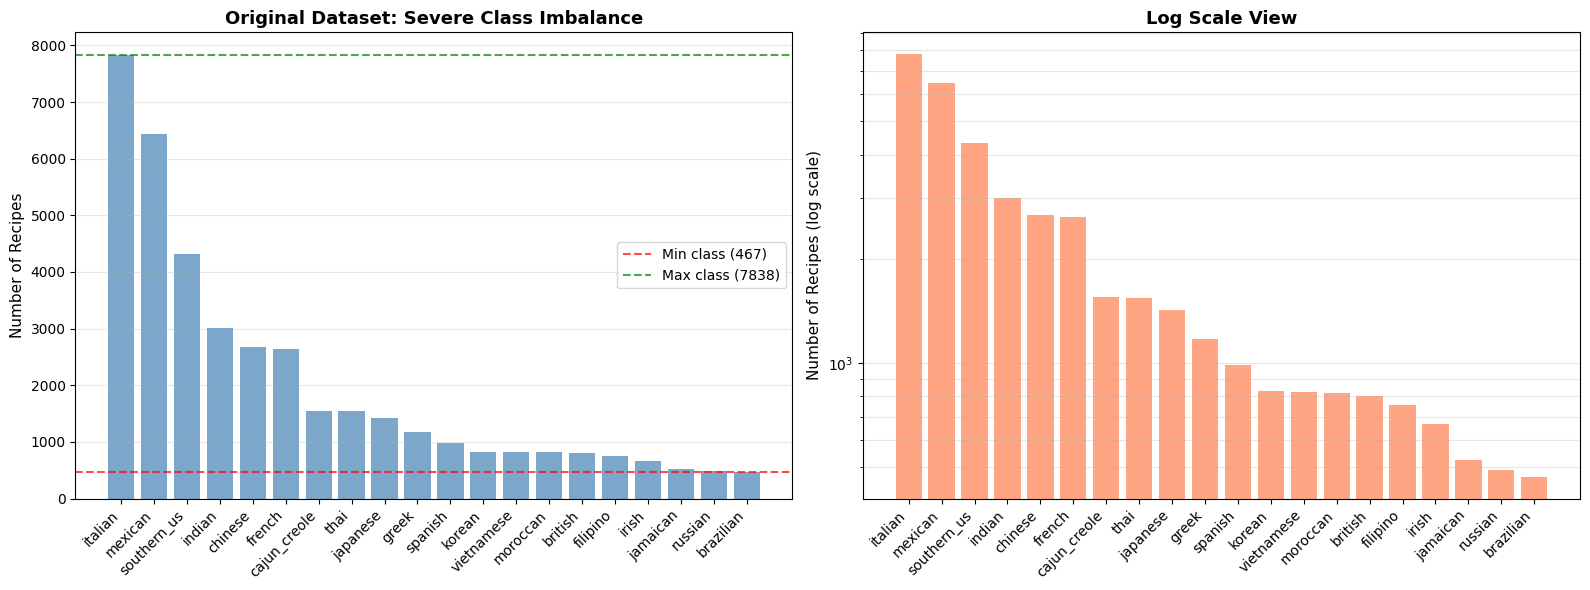

In [7]:
# Analyze class imbalance
print("=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)

cuisine_counts = df['cuisine'].value_counts().sort_values(ascending=False)

print("\nCuisine Distribution:")
print(f"{'Cuisine':<20} {'Count':<10} {'Percentage':<12} {'Ratio to Min':<15}")
print("-" * 80)

min_count = cuisine_counts.min()
max_count = cuisine_counts.max()

for cuisine, count in cuisine_counts.items():
    pct = (count / len(df)) * 100
    ratio = count / min_count
    print(f"{cuisine:<20} {count:<10} {pct:>10.2f}%  {ratio:>13.1f}x")

print(f"\nImbalance Ratio (Max/Min): {max_count / min_count:.1f}x")
print(f"Smallest class: {cuisine_counts.idxmin()} ({min_count} recipes)")
print(f"Largest class: {cuisine_counts.idxmax()} ({max_count} recipes)")

# Visualize imbalance
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
ax1.bar(range(len(cuisine_counts)), cuisine_counts.values, color='steelblue', alpha=0.7)
ax1.set_xticks(range(len(cuisine_counts)))
ax1.set_xticklabels(cuisine_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Number of Recipes', fontsize=11)
ax1.set_title('Original Dataset: Severe Class Imbalance', fontsize=13, fontweight='bold')
ax1.axhline(y=min_count, color='red', linestyle='--', label=f'Min class ({min_count})', alpha=0.7)
ax1.axhline(y=max_count, color='green', linestyle='--', label=f'Max class ({max_count})', alpha=0.7)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Log scale for better visibility
ax2.bar(range(len(cuisine_counts)), cuisine_counts.values, color='coral', alpha=0.7)
ax2.set_xticks(range(len(cuisine_counts)))
ax2.set_xticklabels(cuisine_counts.index, rotation=45, ha='right')
ax2.set_ylabel('Number of Recipes (log scale)', fontsize=11)
ax2.set_yscale('log')
ax2.set_title('Log Scale View', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, which='both')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

print("=" * 80)
print("IMPLEMENTING CLUSTER-BASED STRATIFIED UNDERSAMPLING")
print("=" * 80)

# Step 1: Set target size (smallest class)
target_size = cuisine_counts.min()
print(f"\nTarget size per cuisine: {target_size} recipes")
print(f"Based on smallest class: {cuisine_counts.idxmin()}")

# Step 2: Convert ingredients to binary vectors for clustering
print("\nConverting ingredients to binary feature vectors...")

def parse_ingredients(ing_string):
    """Parse comma-separated ingredient string into list"""
    return ing_string.split(',') if ing_string else []

df['ingredient_list'] = df['ingredients'].apply(parse_ingredients)

# Create binary matrix (recipe x ingredient)
mlb = MultiLabelBinarizer(sparse_output=False)
ingredient_matrix = mlb.fit_transform(df['ingredient_list'])
ingredient_names = mlb.classes_

print(f"Feature matrix: {ingredient_matrix.shape[0]} recipes × {ingredient_matrix.shape[1]} ingredients")

# Step 3: Balance each cuisine
balanced_dfs = []

print("\n" + "-" * 80)
print("Processing each cuisine:")
print("-" * 80)

for cuisine in cuisine_counts.index:
    cuisine_df = df[df['cuisine'] == cuisine].copy()
    cuisine_size = len(cuisine_df)
    cuisine_matrix = ingredient_matrix[df['cuisine'] == cuisine]
    
    # Determine strategy based on size
    if cuisine_size <= target_size:
        # Keep all recipes if at or below target
        strategy = "KEEP ALL"
        sampled_df = cuisine_df
        
    else:
        # Apply cluster-based undersampling to hit target_size exactly
        strategy = "CLUSTER & SAMPLE"
        
        # Determine number of clusters (k)
        # Use sqrt(n) as a heuristic, bounded between 3 and min(target_size/2, 50)
        n_clusters = min(max(3, int(np.sqrt(cuisine_size))), target_size // 2, 50)
        
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(cuisine_matrix)
        
        # Add cluster labels to dataframe
        cuisine_df['cluster'] = cluster_labels
        
        # Stratified sampling: sample proportionally from each cluster
        # Ensure we sample exactly target_size recipes
        samples_per_cluster = target_size // n_clusters
        remainder = target_size % n_clusters
        
        sampled_indices = []
        clusters_sampled = []
        
        for cluster_id in range(n_clusters):
            cluster_indices = cuisine_df[cuisine_df['cluster'] == cluster_id].index.tolist()
            cluster_size = len(cluster_indices)
            
            if cluster_size == 0:
                continue
            
            # Determine sample size for this cluster
            n_samples = samples_per_cluster + (1 if cluster_id < remainder else 0)
            n_samples = min(n_samples, cluster_size)  # Don't oversample
            
            # Random sample from cluster
            sampled = np.random.choice(cluster_indices, size=n_samples, replace=False)
            sampled_indices.extend(sampled)
            clusters_sampled.append((cluster_id, n_samples, cluster_size))
        
        # If we're short of target due to small clusters, sample more from larger clusters
        shortage = target_size - len(sampled_indices)
        if shortage > 0:
            # Find clusters with remaining samples
            remaining_pool = []
            for cluster_id in range(n_clusters):
                cluster_indices = cuisine_df[cuisine_df['cluster'] == cluster_id].index.tolist()
                unused = [idx for idx in cluster_indices if idx not in sampled_indices]
                remaining_pool.extend(unused)
            
            if len(remaining_pool) >= shortage:
                additional = np.random.choice(remaining_pool, size=shortage, replace=False)
                sampled_indices.extend(additional)
        
        sampled_df = cuisine_df.loc[sampled_indices].drop('cluster', axis=1)
    
    balanced_dfs.append(sampled_df)
    
    print(f"{cuisine:<20} {cuisine_size:>6} → {len(sampled_df):>6}  [{strategy}]" + 
          (f" ({n_clusters} clusters)" if strategy == "CLUSTER & SAMPLE" else ""))

# Step 4: Combine balanced samples
df_balanced = pd.concat(balanced_dfs, ignore_index=True)

# Drop temporary column
df_balanced = df_balanced.drop('ingredient_list', axis=1)

print("\n" + "=" * 80)
print("BALANCING RESULTS")
print("=" * 80)
print(f"Original dataset: {len(df):,} recipes")
print(f"Balanced dataset: {len(df_balanced):,} recipes")
print(f"Reduction: {len(df) - len(df_balanced):,} recipes ({(1 - len(df_balanced)/len(df))*100:.1f}%)")

IMPLEMENTING CLUSTER-BASED STRATIFIED UNDERSAMPLING

Target size per cuisine: 467 recipes
Based on smallest class: brazilian

Converting ingredients to binary feature vectors...
Feature matrix: 39774 recipes × 2229 ingredients

--------------------------------------------------------------------------------
Processing each cuisine:
--------------------------------------------------------------------------------
italian                7838 →    456  [CLUSTER & SAMPLE] (88 clusters)
mexican                6438 →    441  [CLUSTER & SAMPLE] (80 clusters)
southern_us            4320 →    452  [CLUSTER & SAMPLE] (65 clusters)
indian                 3003 →    419  [CLUSTER & SAMPLE] (54 clusters)
chinese                2673 →    449  [CLUSTER & SAMPLE] (51 clusters)
french                 2646 →    410  [CLUSTER & SAMPLE] (51 clusters)
cajun_creole           1546 →    383  [CLUSTER & SAMPLE] (39 clusters)
thai                   1539 →    432  [CLUSTER & SAMPLE] (39 clusters)
japanese         


BALANCE VALIDATION

Cuisine              Original     Balanced     % of Target    
--------------------------------------------------------------------------------
italian              7838         456                   97.6%
mexican              6438         441                   94.4%
southern_us          4320         452                   96.8%
indian               3003         419                   89.7%
chinese              2673         449                   96.1%
french               2646         410                   87.8%
cajun_creole         1546         383                   82.0%
thai                 1539         432                   92.5%
japanese             1423         352                   75.4%
greek                1175         412                   88.2%
spanish              989          329                   70.4%
korean               830          429                   91.9%
vietnamese           825          348                   74.5%
moroccan             821     

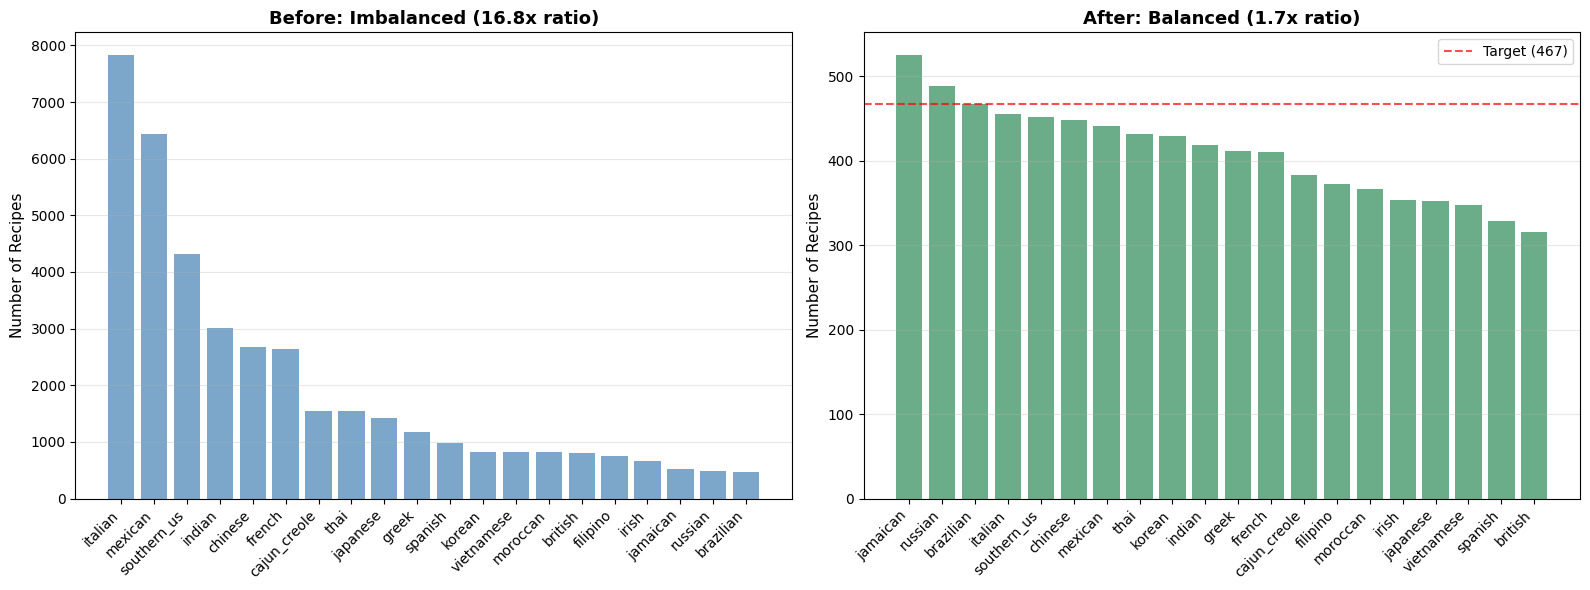


✓ Dataset successfully balanced using cluster-based stratified undersampling
✓ Within-cuisine diversity preserved through clustering
✓ Ready for unbiased association rule mining


In [9]:
# Validate balance
print("\n" + "=" * 80)
print("BALANCE VALIDATION")
print("=" * 80)

balanced_counts = df_balanced['cuisine'].value_counts().sort_values(ascending=False)

print(f"\n{'Cuisine':<20} {'Original':<12} {'Balanced':<12} {'% of Target':<15}")
print("-" * 80)

for cuisine in cuisine_counts.index:
    original = cuisine_counts[cuisine]
    balanced = balanced_counts.get(cuisine, 0)
    pct_of_target = (balanced / target_size) * 100
    print(f"{cuisine:<20} {original:<12} {balanced:<12} {pct_of_target:>13.1f}%")

# Calculate balance metrics
min_balanced = balanced_counts.min()
max_balanced = balanced_counts.max()
balance_ratio = max_balanced / min_balanced

print(f"\nBalance Ratio (Max/Min): {balance_ratio:.2f}x  (was {max_count / min_count:.1f}x)")
print(f"Target achieved: {'✓ Yes' if balance_ratio < 1.5 else '✗ No, needs adjustment'}")

# Visualize balanced distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Before
ax1.bar(range(len(cuisine_counts)), cuisine_counts.values, color='steelblue', alpha=0.7)
ax1.set_xticks(range(len(cuisine_counts)))
ax1.set_xticklabels(cuisine_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Number of Recipes', fontsize=11)
ax1.set_title('Before: Imbalanced (16.8x ratio)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# After
ax2.bar(range(len(balanced_counts)), balanced_counts.values, color='seagreen', alpha=0.7)
ax2.set_xticks(range(len(balanced_counts)))
ax2.set_xticklabels(balanced_counts.index, rotation=45, ha='right')
ax2.set_ylabel('Number of Recipes', fontsize=11)
ax2.set_title(f'After: Balanced ({balance_ratio:.1f}x ratio)', fontsize=13, fontweight='bold')
ax2.axhline(y=target_size, color='red', linestyle='--', label=f'Target ({target_size})', alpha=0.7)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Dataset successfully balanced using cluster-based stratified undersampling")
print("✓ Within-cuisine diversity preserved through clustering")
print("✓ Ready for unbiased association rule mining")

### 6.8 Export Both Datasets

We export **two versions** of the prepared dataset:

1. **`prepared_recipes_cleaned.csv`** (Original, Imbalanced)
   - Full dataset with all 39,774 recipes
   - Use for: Initial exploration, understanding natural data distribution
   
2. **`prepared_recipes_cleaned_balanced.csv`** (Balanced)
   - Cluster-based undersampled dataset (~9,340 recipes)
   - Use for: **Primary association rule mining** to avoid dominant class bias
   
**Recommendation**: Use the **balanced dataset** for Apriori mining to ensure meaningful cross-cuisine pattern discovery without Italian/Mexican dominance.

In [10]:
import os

# Save both datasets
output_path_original = 'dataset/prepared_recipes_cleaned.csv'
output_path_balanced = 'dataset/prepared_recipes_cleaned_balanced.csv'

# Export original (imbalanced) dataset
df.to_csv(output_path_original, index=False)

# Export balanced dataset
df_balanced.to_csv(output_path_balanced, index=False)

print("=" * 80)
print("DATASETS SAVED")
print("=" * 80)

print(f"\n📊 ORIGINAL (IMBALANCED) DATASET:")
print(f"   Path: {output_path_original}")
print(f"   Records: {len(df):,}")
print(f"   Size: {os.path.getsize(output_path_original) / (1024 * 1024):.2f} MB")
print(f"   Use: Initial exploration, natural distribution analysis")

print(f"\n⚖️  BALANCED DATASET:")
print(f"   Path: {output_path_balanced}")
print(f"   Records: {len(df_balanced):,}")
print(f"   Size: {os.path.getsize(output_path_balanced) / (1024 * 1024):.2f} MB")
print(f"   Use: PRIMARY dataset for association rule mining")

print(f"\n✓ Both datasets validated and ready for analysis")
print(f"✓ Recommended: Use balanced dataset for Apriori to avoid bias")

DATASETS SAVED

📊 ORIGINAL (IMBALANCED) DATASET:
   Path: dataset/prepared_recipes_cleaned.csv
   Records: 39,774
   Size: 9.02 MB
   Use: Initial exploration, natural distribution analysis

⚖️  BALANCED DATASET:
   Path: dataset/prepared_recipes_cleaned_balanced.csv
   Records: 8,204
   Size: 0.93 MB
   Use: PRIMARY dataset for association rule mining

✓ Both datasets validated and ready for analysis
✓ Recommended: Use balanced dataset for Apriori to avoid bias
